# Collate all of the FROC data into a single file

In [98]:
from pathlib import Path
import pandas as pd
import json

In [122]:

fpps_recode = {
    0 : 0.125,
    1 : 0.25,
    2 : 0.5,
    3 : 1,
    4 : 2,
    5 : 4,
    6 : 8
}

froc_paths = Path('results').rglob('*_froc.json')
froc_data = pd.concat([
    (
        pd.DataFrame(category_data)
        .reset_index()
        .rename(columns={'index': 'fpps'})
        .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
        .assign(category=category_json)
        .assign(path=froc_path.as_posix())
    )
    for froc_path in froc_paths
    for category_json, category_data in json.load(froc_path.open()).items()
])

froc_data[['a','dataset','filename']] = froc_data.path.str.split('/', expand=True)
froc_data['model']=froc_data.filename.str.split('_').str[0]
froc_data['flavour']=froc_data.filename.str.split('_').str[1].str.cat(froc_data.filename.str.split('_').str[2], sep='_')
froc_data['error']=froc_data['high_sens'] - froc_data['low_sens']
froc_data.drop(columns=['path','a','filename'], inplace=True)
froc_data.to_csv('froc_data.csv', index=False)
froc_data.query("flavour == 'test_balanced' and category.str.lower() in ['male','female']")

,fpps,mean_sens,low_sens,high_sens,category,dataset,model,flavour,error
0,0.125,0.174,0.099,0.254,MALE,summit,grt123,test_balanced,0.155
1,0.250,0.219,0.138,0.307,MALE,summit,grt123,test_balanced,0.169
2,0.500,0.308,0.213,0.414,MALE,summit,grt123,test_balanced,0.201
3,1.000,0.392,0.289,0.496,MALE,summit,grt123,test_balanced,0.207
4,2.000,0.458,0.356,0.563,MALE,summit,grt123,test_balanced,0.207
...,...,...,...,...,...,...,...,...,...
2,0.500,0.449,0.315,0.603,Female,lsut,ticnet,test_balanced,0.288
3,1.000,0.538,0.425,0.667,Female,lsut,ticnet,test_balanced,0.242
4,2.000,0.642,0.505,0.786,Female,lsut,ticnet,test_balanced,0.281
5,4.000,0.704,0.562,0.853,Female,lsut,ticnet,test_balanced,0.291


# Plot the FROC Error Bar Plots

In [123]:
from re import sub
from cv2 import rotate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_frocs(dataset, map_data, flavour):
      # Example Data (Replace with your actual dataset)
      df = map_data.query('dataset == @dataset and flavour == @flavour')

      # Set up bar plot
      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(14, 4), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(14, 4), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharey=True, sharex=True)

      # Define positions for bars
      bar_width = 0.1
      categories_top = ['FEMALE', 'MALE' ] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }
      # Increase font size by 150%
      fontsize = 12 * 1.25

      # Plot bars for each model and category
      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                  # Top row plots
                  ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                  for j, category in enumerate(categories_top):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))
                        ax_top.errorbar(
                              positions + j * bar_width, 
                              subset['mean_sens'], 
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'], 
                                    subset['high_sens'] - subset['mean_sens']
                              ],
                              fmt='o', 
                              label=category.replace('FEMALE','Female').replace('MALE','Male'),
                              capsize=2,
                              alpha=0.8
                  )                       
                  ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                  ax_top.set_xticks(positions + bar_width / 2)
                  ax_top.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=45)

                  if flavour == 'white_only' and i == 1:
                        ax_top.set_xlabel("False Positives Per Scan", fontsize=fontsize)

                  if i == 0 :
                        ax_top.set_ylabel("Sensitivity", fontsize=fontsize)

                  ax_top.grid(axis="y", linestyle="--", alpha=0.7)
                  if i == 0:
                        ax_top.legend(loc='upper left', fontsize=fontsize)

            if flavour != 'white_only':
                  # Bottom row plots
                  ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                  for j, category in enumerate(categories_bottom):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))                      
                        ax_bottom.errorbar(
                              positions + j * bar_width, 
                              subset['mean_sens'], 
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'], 
                                    subset['high_sens'] - subset['mean_sens']
                              ], 
                              fmt='o',
                              label=category.replace('Asian or Asian British','Asian'),
                              capsize=2,
                              alpha=0.8
                  )         
                  ax_bottom.set_xticks(positions + bar_width / 2)
                  ax_bottom.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=45)

                  if i == 0:
                        ax_bottom.legend(loc='upper left', fontsize=fontsize)

                  if i == 0:
                        ax_bottom.set_ylabel("Sensitivity", fontsize=fontsize)

                  if i == 1:
                        ax_bottom.set_xlabel("False Positives Per Scan", fontsize=fontsize)

                  ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)

      plt.savefig(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png')
      plt.tight_layout()
      plt.show()


********************************************************************************
Flavour: test_balanced


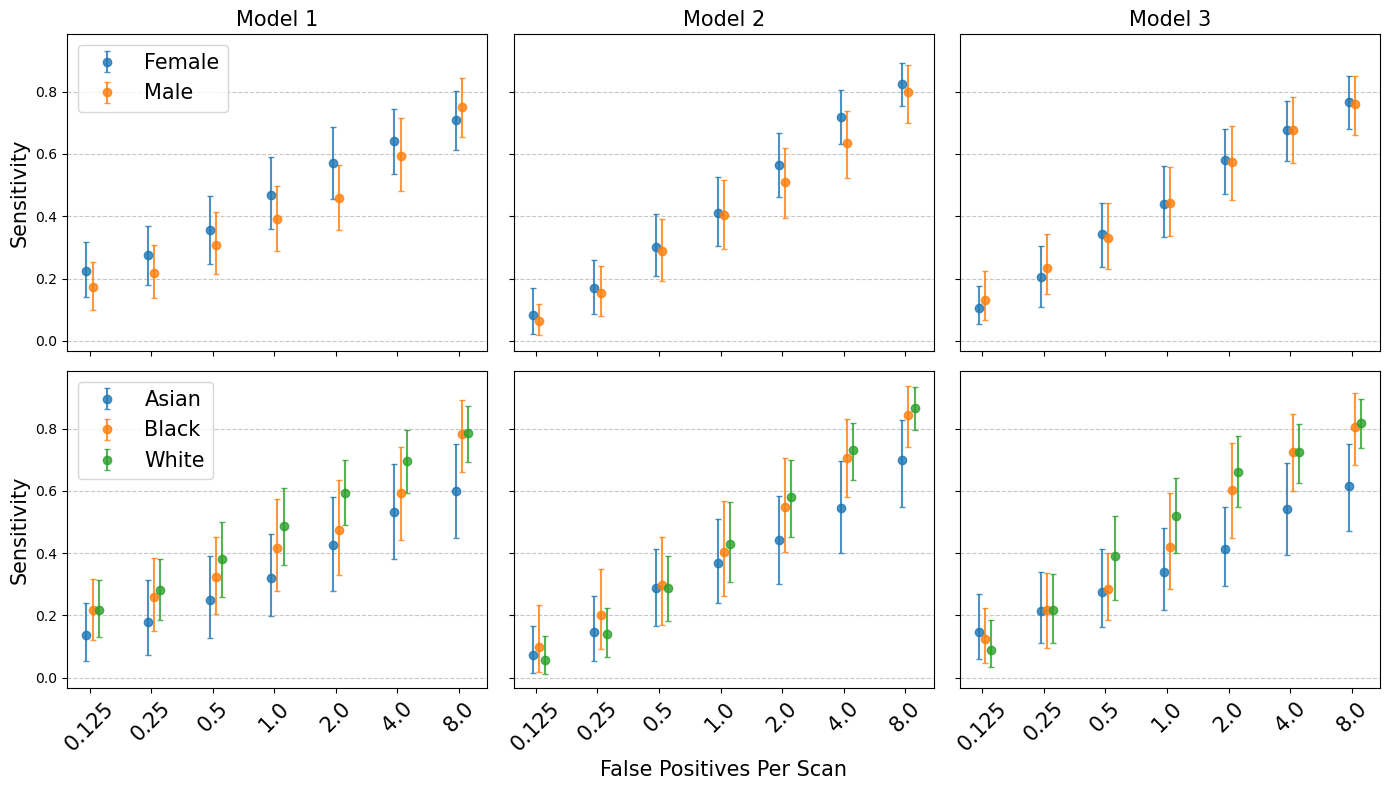

********************************************************************************
Flavour: male_only


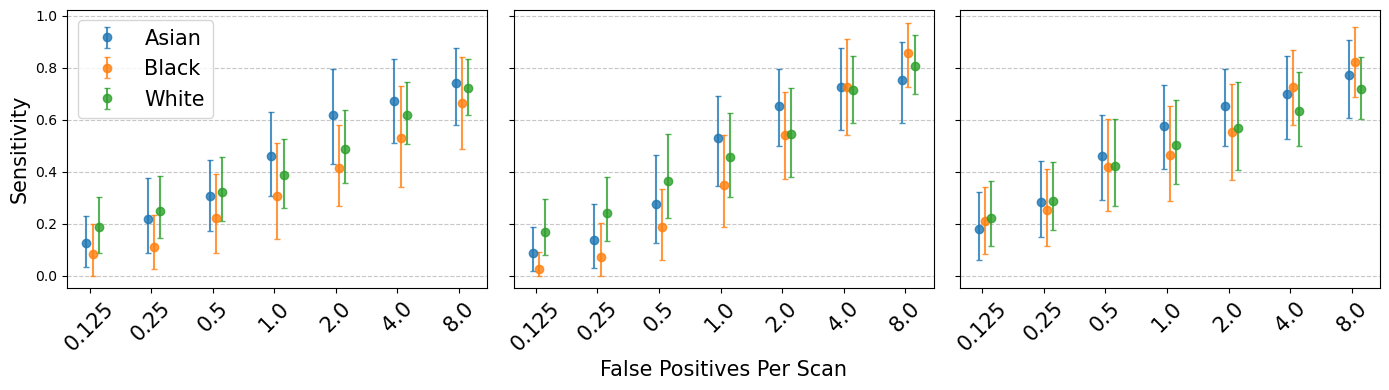

********************************************************************************
Flavour: white_only


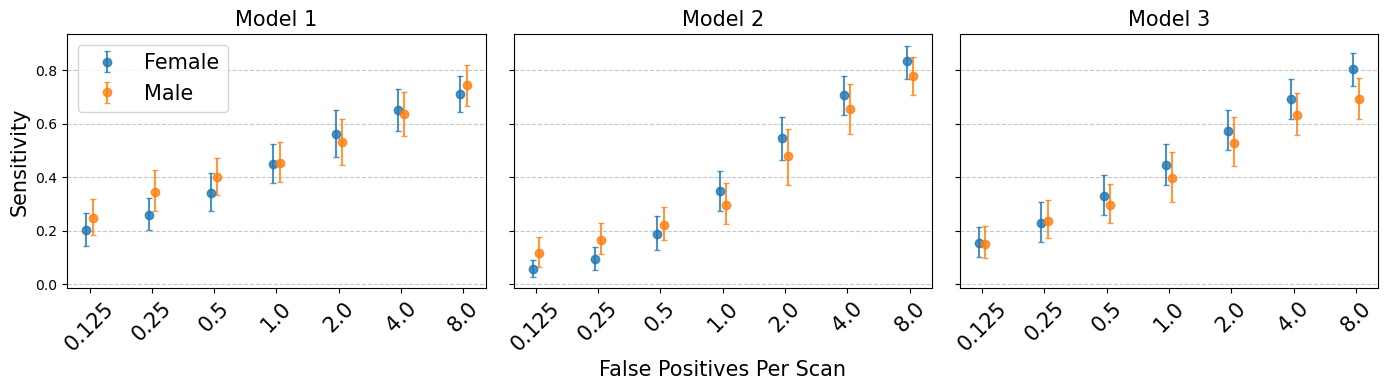

********************************************************************************
Flavour: test_balanced


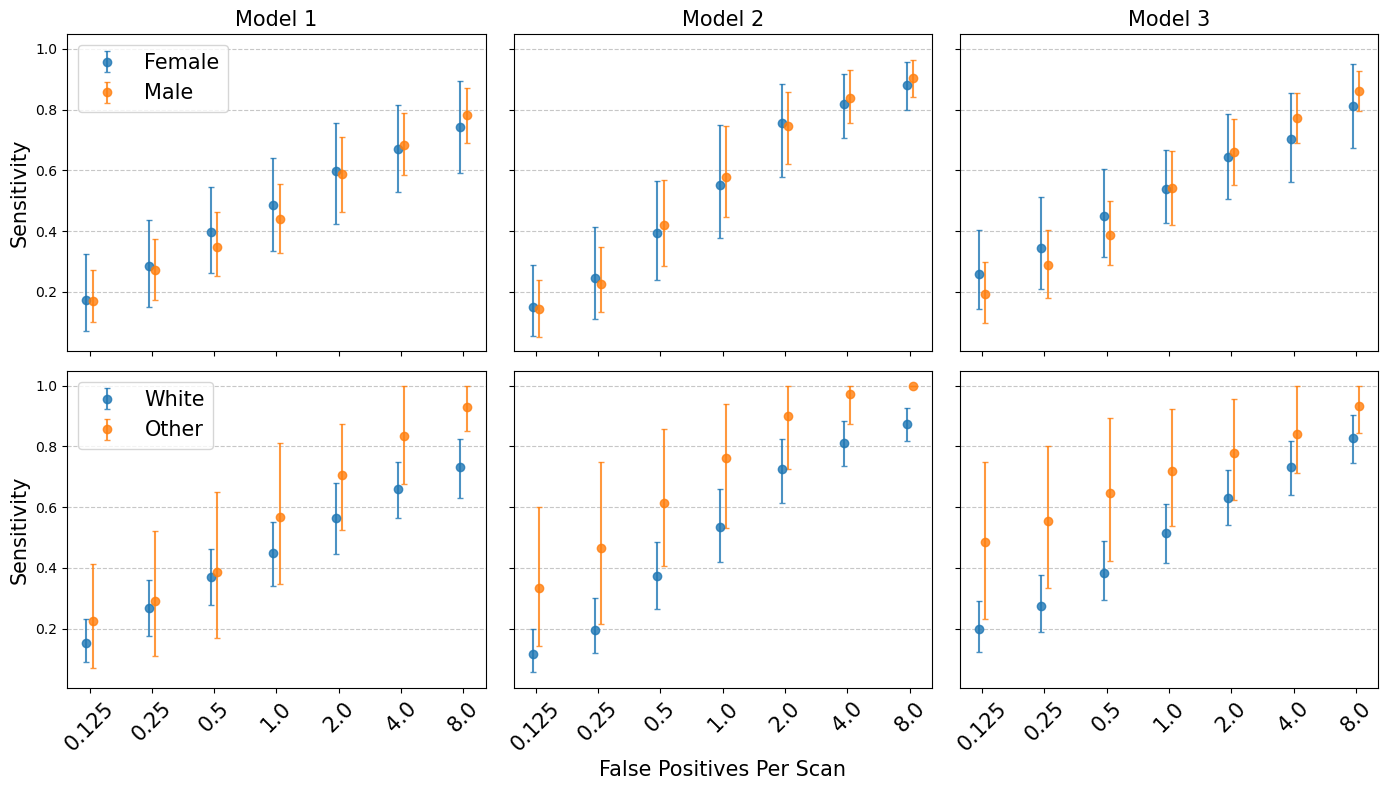

In [124]:

for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)

# Collate all of the CMP data into a single file

In [121]:


cpm_summary_paths = Path('results').rglob('cpm_summary.csv')
cpm_summary_paths = pd.concat([
    (
        pd.read_csv(p)
        .assign(path=p.as_posix())
        .rename(columns={'Unnamed: 0':'category', '0' :'CPM'})
    )
    for p in cpm_summary_paths
])

cpm_summary_paths[['a','dataset','model','flavour','c','d','e']] = cpm_summary_paths.path.str.split('/', expand=True)
cpm_data = cpm_summary_paths.filter(['dataset', 'model','flavour','category','CPM']).query('CPM.notnull()')
cpm_data[['cpm_mean', 'cpm_lower', 'cpm_upper']] = cpm_data['CPM'].str.extract(r'(\d+\.\d+)\s+\(95%\s+CI\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
cpm_data.to_csv('results/cpms.csv', index=False)

cpm_data.query('flavour == "test_balanced" and category.str.lower() not  in ["male","female"]').sort_values(['category','model']).to_clipboard(index=False)

# Collate CI

In [103]:
import json
import numpy as np

# Collate the mAP scores
CI_paths = Path('results').rglob('*_ci.json')
CI_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'ci_lower', 1:'ci_upper'})
        .assign(ci=lambda df: np.round(df['ci_lower'],2).astype(str).str.cat(np.round(df['ci_upper'],2).astype(str), sep=' - '))
        .assign(path=p.as_posix())
    )
    for p in CI_paths
])

CI_paths['dataset'] = CI_paths.path.str.split('/').str[1]
CI_paths['x'] = CI_paths.path.str.split('/').str[-1]
CI_paths[['model','p1','p2','d1']] = CI_paths.x.str.split('_', expand=True)
CI_paths['flavour'] = CI_paths.p1.str.cat(CI_paths.p2, sep='_')

ci_data = CI_paths.filter(['dataset', 'model','flavour','category','iou','ci_lower','ci_upper'])
ci_data.to_csv('results/cis.csv', index=False)

ci_data.query('dataset == "summit" and flavour == "white_only"')

,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,detection,white_only,MALE_vs_FEMALE,-1.193388,0.327856
0,summit,grt123,white_only,MALE_vs_FEMALE,-0.749292,0.842081
0,summit,ticnet,white_only,MALE_vs_FEMALE,-1.319189,0.128696


# Plot CI

********************************************************************************
Dataset: summit
********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,grt123,test_balanced,MALE_vs_FEMALE,-1.222687,0.713951
3,summit,grt123,test_balanced,Black_vs_White,-1.776878,0.633235
2,summit,grt123,test_balanced,Asian or Asian British_vs_White,-2.593029,-0.101340
1,summit,grt123,test_balanced,Asian or Asian British_vs_Black,-2.253921,0.680027


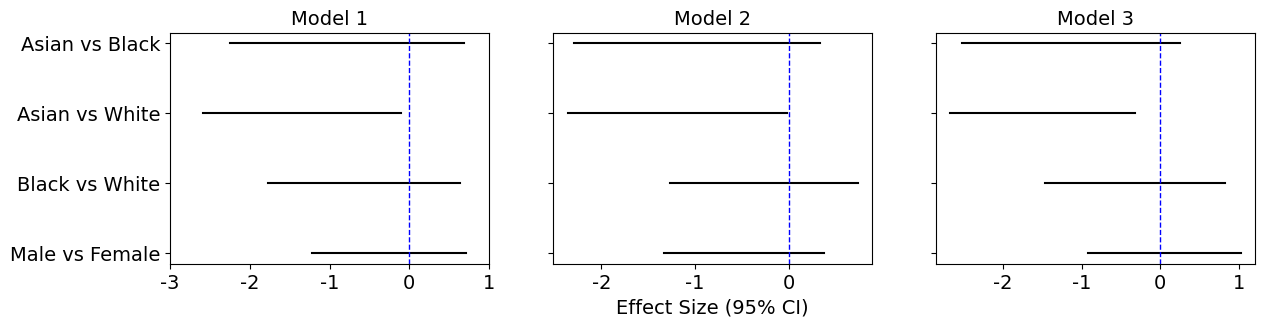

********************************************************************************
Flavour: male_only


,dataset,model,flavour,category,ci_lower,ci_upper
2,summit,grt123,male_only,Black_vs_White,-2.190456,0.874479
1,summit,grt123,male_only,Asian or Asian British_vs_White,-1.236736,1.774036
0,summit,grt123,male_only,Asian or Asian British_vs_Black,-0.598654,2.909794


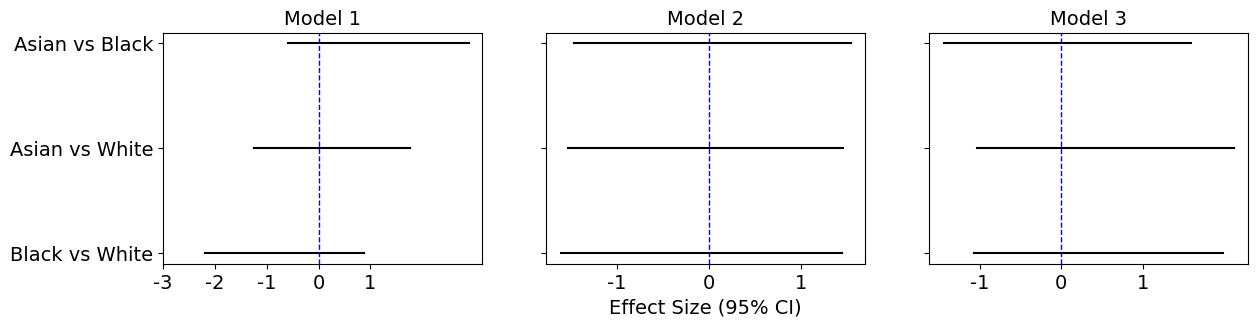

********************************************************************************
Flavour: white_only


,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,grt123,white_only,MALE_vs_FEMALE,-0.749292,0.842081


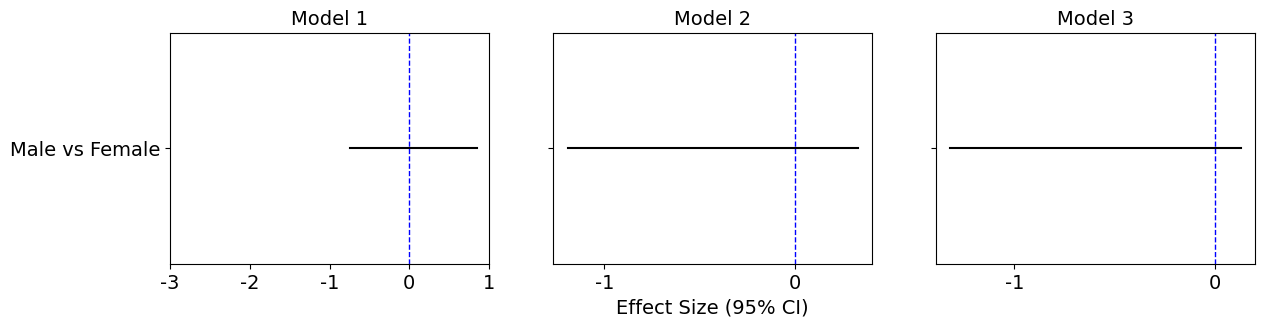

********************************************************************************
Dataset: lsut
********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,ci_lower,ci_upper
1,lsut,grt123,test_balanced,White_vs_Other,-2.487971,-0.197529
0,lsut,grt123,test_balanced,Male_vs_Female,-1.156869,1.471248


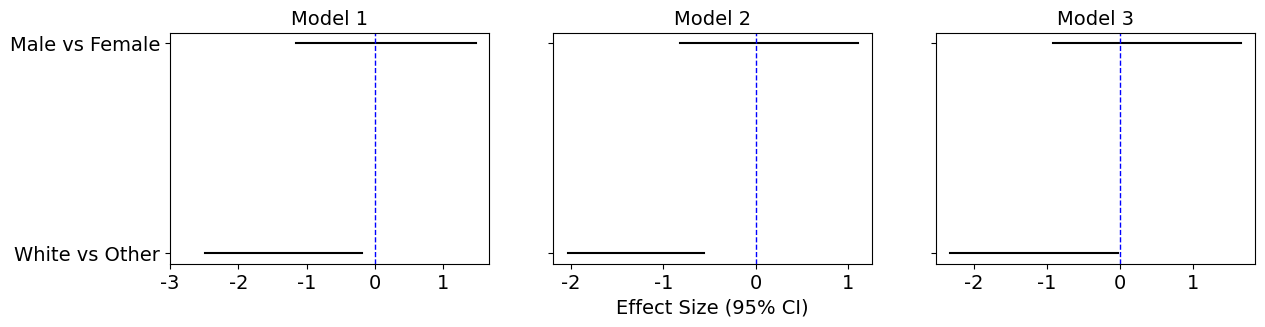

********************************************************************************
Flavour: male_only


,dataset,model,flavour,category,ci_lower,ci_upper


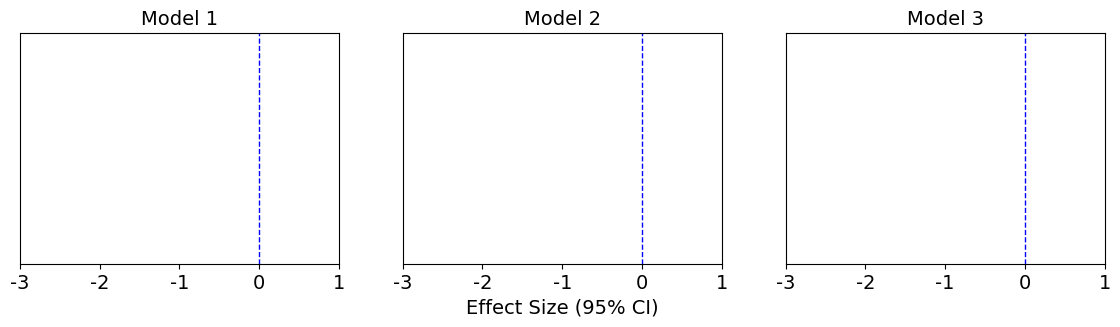

********************************************************************************
Flavour: white_only


,dataset,model,flavour,category,ci_lower,ci_upper


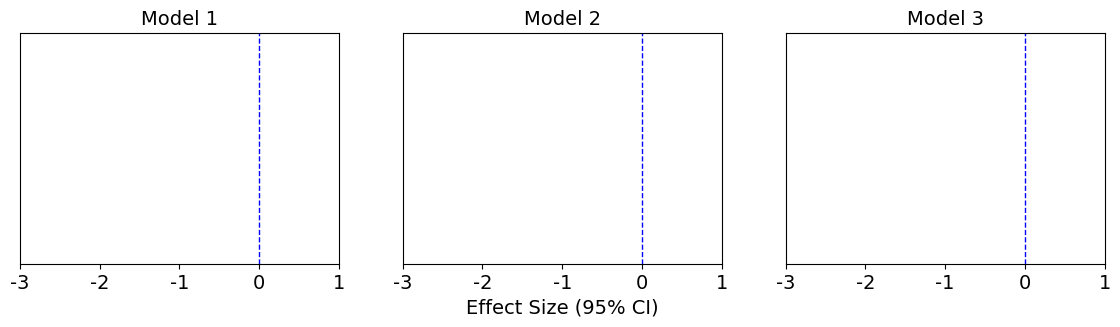

In [104]:

import pandas as pd
import matplotlib.pyplot as plt

for dataset in ['summit', 'lsut']:

    print('*'*80)
    print(f"Dataset: {dataset}")

    for flavour in ['test_balanced', 'male_only', 'white_only']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        order = [
            'MALE_vs_FEMALE',
            'Asian or Asian British_vs_Black',
            'Asian or Asian British_vs_White',
            'Black_vs_White'
            ]

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"').sort_values('category', ascending=True)
        df_grt123 = df.query('model == "grt123"').sort_values('category', ascending=False)
        df_ticnet = df.query('model == "ticnet"').sort_values('category', ascending=False)

        # display(df_detection)
        display(df_grt123)
        # display(df_ticnet)

        # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3), sharey=True)

        ylabels = []
        # Plot for grt123 model
        axes[0].set_title('Model 1', fontsize=14)
        for _, row in df_grt123.iterrows():
            axes[0].plot([row['ci_lower'], row['ci_upper']], [row['category'], row['category']], color='black', lw=1.5)
            # axes[0].scatter((row['ci_lower'] + row['ci_upper']) / 2, row.name, color='red', zorder=3)

        ylabels = (
            df_grt123['category']
            .apply(
                lambda x: x.replace('_', ' ')
                .replace('FEMALE', 'Female')
                .replace('MALE','Male')
                .replace('Asian or Asian British', 'Asian')
                .replace('Black', 'Black')
                .replace('White', 'White')
            )
        )

        axes[0].axvline(x=0, color='blue', linestyle='--', lw=1)
        axes[0].set_xticks([-3, -2, -1, 0, 1])
        axes[0].set_xticklabels([-3, -2, -1, 0, 1], fontsize=14)
        axes[0].set_yticks(range(len(df_detection)))
        axes[0].set_yticklabels(ylabels, fontsize=14)
        # axes[0].set_xlabel("Effect Size (95% CI)")

        # Plot for detection model
        axes[1].set_title('Model 2', fontsize=14)
        axes[1].set_xticks([-3, -2, -1, 0, 1])
        axes[1].set_xticklabels([-3, -2, -1, 0, 1], fontsize=14)

        for _, row in df_detection.iterrows():
            axes[1].plot([row['ci_lower'], row['ci_upper']], [row['category'], row['category']], color='black', lw=1.5)
            # axes[1].scatter((row['ci_lower'] + row['ci_upper']) / 2, row.name, color='red', zorder=3)
        axes[1].axvline(x=0, color='blue', linestyle='--', lw=1)
        axes[1].set_yticks(range(len(df_detection)))
        # axes[1].set_yticklabels(df_detection['category'].apply(lambda x: x.replace('_', ' ').replace('FEMALE', 'Female').replace('MALE', 'Male')))
        axes[1].set_xlabel("Effect Size (95% CI)", fontsize=14)

        # Plot for ticnet model
        axes[2].set_title('Model 3', fontsize=14)
        axes[2].set_xticks([-3, -2, -1, 0, 1])
        axes[2].set_xticklabels([-3, -2, -1, 0, 1], fontsize=14)        
        for _, row in df_ticnet.iterrows():
            axes[2].plot([row['ci_lower'], row['ci_upper']], [row['category'], row['category']], color='black', lw=1.5)
            # axes[2].scatter((row['ci_lower'] + row['ci_upper']) / 2, row.name, color='red', zorder=3)
        axes[2].axvline(x=0, color='blue', linestyle='--', lw=1)
        # axes[2].set_xlabel("Effect Size (95% CI)")

        # Set common y-label
        # fig.text(0.04, 0.5, 'Category', va='center', rotation='vertical')

        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_plot.png')

        # plt.tight_layout()
        plt.show()

# Combine mAPs

In [125]:
import json

# Collate the mAP scores
mAP_paths = Path('results').rglob('*mean_mAPs.json')
mAP_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'mAP'})
        .assign(path=p.as_posix())
    )
    for p in mAP_paths
])

mAP_paths.path.str.split('/', expand=True)

mAP_paths[['d0', 'dataset', 'file_name']] = mAP_paths.path.str.split('/', expand=True)
mAP_paths[['model','p1','p2','iou','d1','d2']] = mAP_paths.file_name.str.split('_', expand=True)
mAP_paths['flavour'] = mAP_paths.p1.str.cat(mAP_paths.p2, sep='_')
mAP_paths['category'] = mAP_paths.category.str.split('_').str[-1]
map_data = mAP_paths.filter(['dataset', 'model','flavour','category','iou', 'mAP'])
# Extract map_mean, lower and upper values
map_data[['map_mean', 'map_lower', 'map_upper']] = map_data['mAP'].str.extract(r'(\d+\.\d+)\s+\(CI\s+95%\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
# Compute error bars (Upper - Mean, Mean - Lower)
map_data["map_error_lower"] = map_data["map_mean"] - map_data["map_lower"]
map_data["map_error_upper"] = map_data["map_upper"] - map_data["map_mean"]

map_data.to_csv('results/mAPs.csv', index=False)
map_data.query('dataset == "lsut" and flavour == "test_balanced" and category not in ["Male","Female", "all"]')[['dataset','model','flavour','category','iou','mAP']].sort_values(['model','category','iou'])

,dataset,model,flavour,category,iou,mAP
3,lsut,detection,test_balanced,Other,0.1,0.24 (CI 95% 0.14-0.36)
4,lsut,detection,test_balanced,Other,0.3,0.24 (CI 95% 0.13-0.35)
0,lsut,detection,test_balanced,Other,0.5,0.2 (CI 95% 0.1-0.32)
4,lsut,detection,test_balanced,White,0.1,0.23 (CI 95% 0.19-0.28)
2,lsut,detection,test_balanced,White,0.3,0.22 (CI 95% 0.18-0.27)
4,lsut,detection,test_balanced,White,0.5,0.18 (CI 95% 0.14-0.23)
2,lsut,grt123,test_balanced,Other,0.1,0.22 (CI 95% 0.13-0.33)
4,lsut,grt123,test_balanced,Other,0.3,0.2 (CI 95% 0.1-0.3)
3,lsut,grt123,test_balanced,Other,0.5,0.12 (CI 95% 0.05-0.2)
4,lsut,grt123,test_balanced,White,0.1,0.23 (CI 95% 0.18-0.27)


# Plot mAP

********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,test_balanced,MALE,0.1,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,test_balanced,Black,0.1,0.1 (CI 95% 0.07-0.14),0.10,0.07,0.14,0.03,0.04
2,summit,detection,test_balanced,FEMALE,0.1,0.15 (CI 95% 0.11-0.19),0.15,0.11,0.19,0.04,0.04
3,summit,detection,test_balanced,White,0.1,0.17 (CI 95% 0.13-0.22),0.17,0.13,0.22,0.04,0.05
4,summit,detection,test_balanced,all,0.1,0.13 (CI 95% 0.1-0.15),0.13,0.10,0.15,0.03,0.02
5,summit,detection,test_balanced,Asian or Asian British,0.1,0.11 (CI 95% 0.07-0.15),0.11,0.07,0.15,0.04,0.04
0,summit,detection,test_balanced,MALE,0.3,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,test_balanced,FEMALE,0.3,0.13 (CI 95% 0.09-0.16),0.13,0.09,0.16,0.04,0.03
2,summit,detection,test_balanced,White,0.3,0.15 (CI 95% 0.11-0.2),0.15,0.11,0.20,0.04,0.05
3,summit,detection,test_balanced,Asian or Asian British,0.3,0.09 (CI 95% 0.06-0.13),0.09,0.06,0.13,0.03,0.04


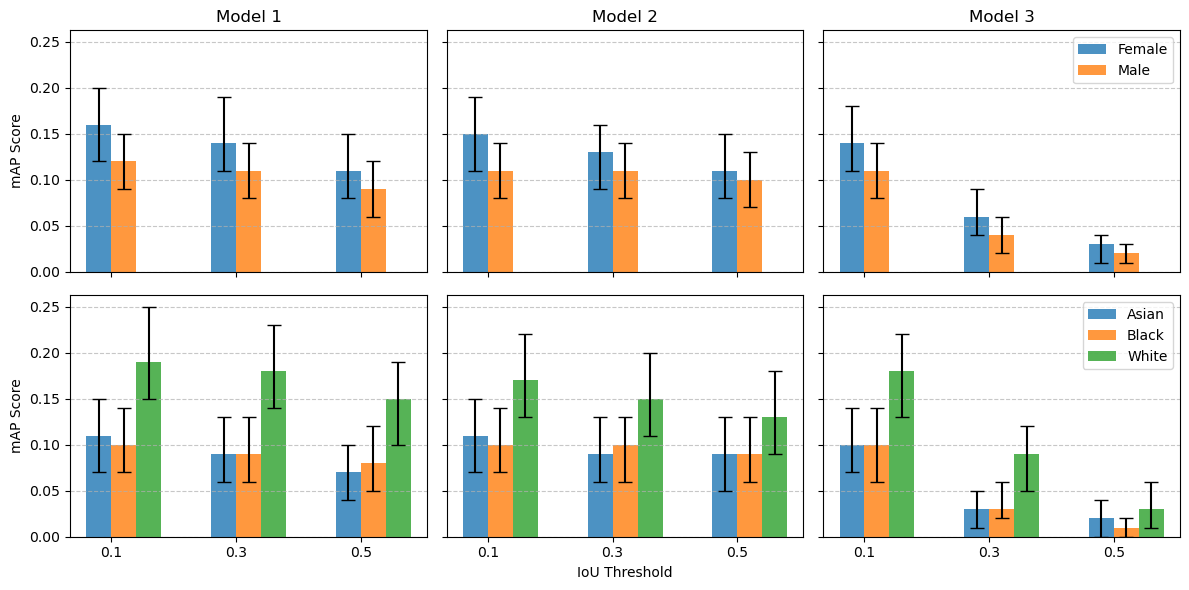

********************************************************************************
Flavour: male_only


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,male_only,all,0.1,0.13 (CI 95% 0.11-0.17),0.13,0.11,0.17,0.02,0.04
1,summit,detection,male_only,Asian or Asian British,0.1,0.11 (CI 95% 0.07-0.16),0.11,0.07,0.16,0.04,0.05
2,summit,detection,male_only,Black,0.1,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04
3,summit,detection,male_only,White,0.1,0.2 (CI 95% 0.14-0.26),0.20,0.14,0.26,0.06,0.06
0,summit,detection,male_only,all,0.3,0.13 (CI 95% 0.1-0.16),0.13,0.10,0.16,0.03,0.03
1,summit,detection,male_only,Asian or Asian British,0.3,0.11 (CI 95% 0.07-0.16),0.11,0.07,0.16,0.04,0.05
2,summit,detection,male_only,Black,0.3,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04
3,summit,detection,male_only,White,0.3,0.19 (CI 95% 0.13-0.25),0.19,0.13,0.25,0.06,0.06
0,summit,detection,male_only,all,0.5,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,male_only,Asian or Asian British,0.5,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04


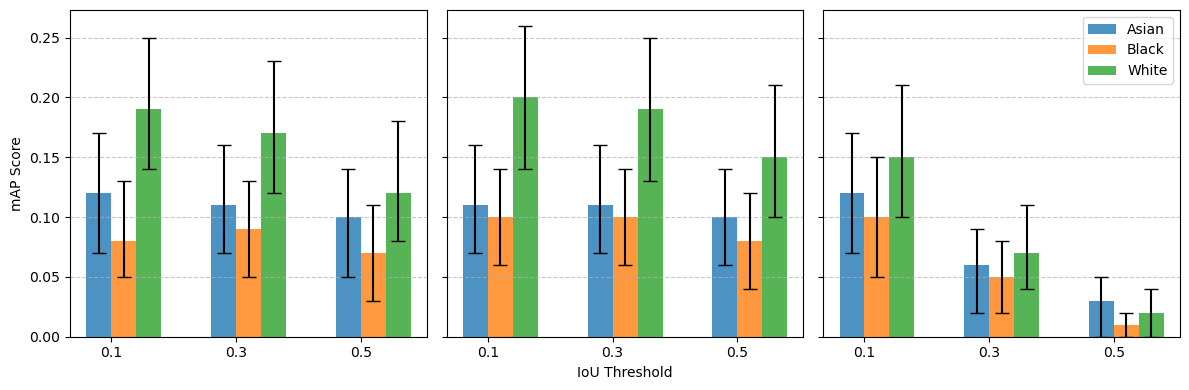

********************************************************************************
Flavour: white_only


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,white_only,all,0.1,0.16 (CI 95% 0.14-0.19),0.16,0.14,0.19,0.02,0.03
1,summit,detection,white_only,MALE,0.1,0.16 (CI 95% 0.12-0.19),0.16,0.12,0.19,0.04,0.03
2,summit,detection,white_only,FEMALE,0.1,0.17 (CI 95% 0.14-0.2),0.17,0.14,0.20,0.03,0.03
0,summit,detection,white_only,all,0.3,0.16 (CI 95% 0.13-0.18),0.16,0.13,0.18,0.03,0.02
1,summit,detection,white_only,MALE,0.3,0.15 (CI 95% 0.12-0.18),0.15,0.12,0.18,0.03,0.03
2,summit,detection,white_only,FEMALE,0.3,0.16 (CI 95% 0.13-0.19),0.16,0.13,0.19,0.03,0.03
0,summit,detection,white_only,all,0.5,0.14 (CI 95% 0.12-0.16),0.14,0.12,0.16,0.02,0.02
1,summit,detection,white_only,MALE,0.5,0.13 (CI 95% 0.11-0.16),0.13,0.11,0.16,0.02,0.03
2,summit,detection,white_only,FEMALE,0.5,0.14 (CI 95% 0.11-0.17),0.14,0.11,0.17,0.03,0.03
0,summit,grt123,white_only,all,0.1,0.18 (CI 95% 0.16-0.21),0.18,0.16,0.21,0.02,0.03


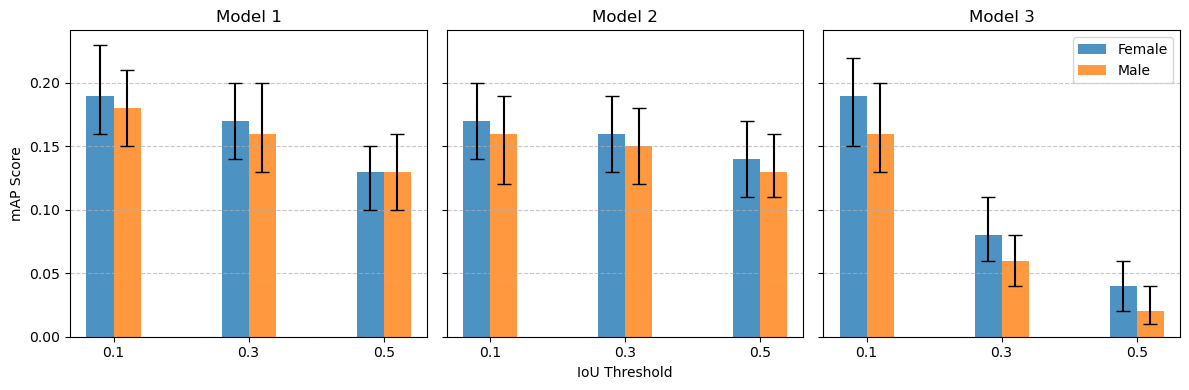

********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,lsut,detection,test_balanced,Female,0.1,0.27 (CI 95% 0.21-0.35),0.27,0.21,0.35,0.06,0.08
1,lsut,detection,test_balanced,Male,0.1,0.2 (CI 95% 0.15-0.26),0.20,0.15,0.26,0.05,0.06
2,lsut,detection,test_balanced,all,0.1,0.23 (CI 95% 0.19-0.28),0.23,0.19,0.28,0.04,0.05
3,lsut,detection,test_balanced,Other,0.1,0.24 (CI 95% 0.14-0.36),0.24,0.14,0.36,0.10,0.12
4,lsut,detection,test_balanced,White,0.1,0.23 (CI 95% 0.19-0.28),0.23,0.19,0.28,0.04,0.05
0,lsut,detection,test_balanced,all,0.3,0.22 (CI 95% 0.19-0.26),0.22,0.19,0.26,0.03,0.04
1,lsut,detection,test_balanced,Female,0.3,0.26 (CI 95% 0.2-0.33),0.26,0.20,0.33,0.06,0.07
2,lsut,detection,test_balanced,White,0.3,0.22 (CI 95% 0.18-0.27),0.22,0.18,0.27,0.04,0.05
3,lsut,detection,test_balanced,Male,0.3,0.2 (CI 95% 0.14-0.25),0.20,0.14,0.25,0.06,0.05
4,lsut,detection,test_balanced,Other,0.3,0.24 (CI 95% 0.13-0.35),0.24,0.13,0.35,0.11,0.11


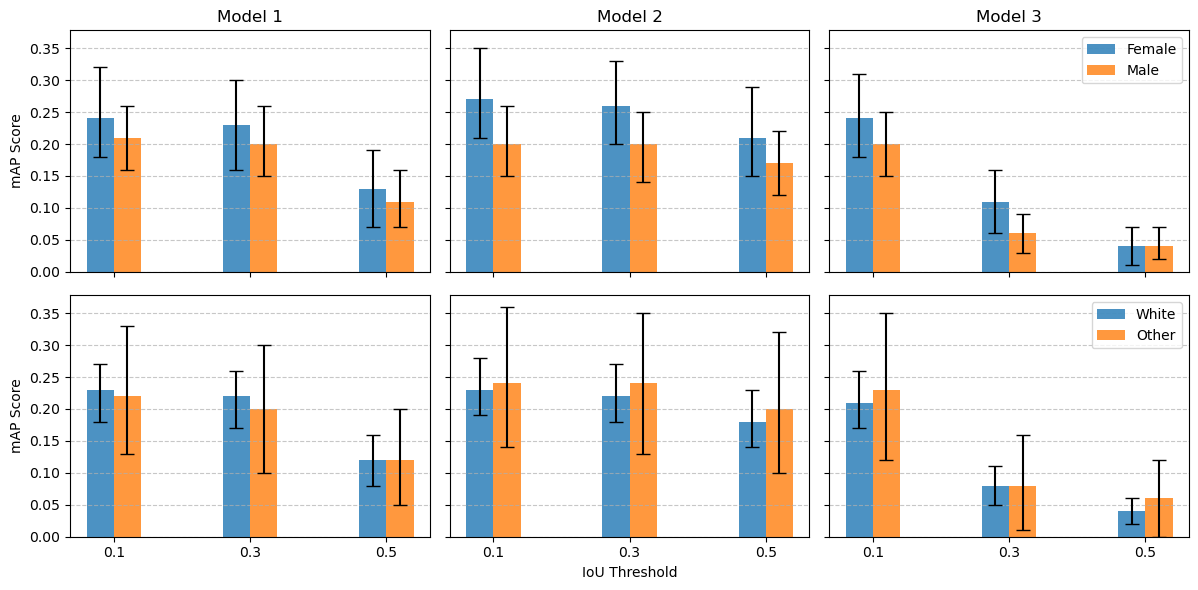

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_maps(dataset, map_data, flavour):
      # Example Data (Replace with your actual dataset)
      df = map_data.query('dataset == @dataset and flavour == @flavour').sort_values(['model','iou'])

      display(df)

      # Set up bar plot
      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharey=True, sharex=True)

      # Define positions for bars
      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE' ] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }

      # Plot bars for each model and category
      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                  # Top row plots
                  ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                  for j, category in enumerate(categories_top):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['iou'].unique()))
                        ax_top.bar(
                              positions + j * bar_width, 
                              subset['map_mean'], 
                              width=bar_width,
                              yerr=[
                                    subset['map_error_lower'],
                                    subset['map_error_upper']
                              ],
                              capsize=5,
                              label=category.replace('FEMALE','Female').replace('MALE','Male'),
                              alpha=0.8
                        )
                        
                  ax_top.set_title(f'{model_mappings[model]}')
                  ax_top.set_xticks(positions + bar_width / 2)
                  ax_top.set_xticklabels(subset['iou'].unique())

                  if flavour == 'white_only' and i == 1:
                        ax_top.set_xlabel("IoU Threshold")

                  if i == 0 :
                        ax_top.set_ylabel("mAP Score")

                  ax_top.grid(axis="y", linestyle="--", alpha=0.7)
                  if i == 2:
                        ax_top.legend(loc='upper right')

            if flavour != 'white_only':
                  # Bottom row plots
                  ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                  for j, category in enumerate(categories_bottom):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['iou'].unique()))
                        ax_bottom.bar(
                              positions + j * bar_width,
                              subset['map_mean'],
                              width=bar_width,
                              yerr=[
                                    subset['map_error_lower'],
                                    subset['map_error_upper']
                              ],
                              capsize=5,
                              label=category.replace('Asian or Asian British', 'Asian'),
                              alpha=0.8
                        )
                  ax_bottom.set_xticks(positions + bar_width / 2)
                  ax_bottom.set_xticklabels(subset['iou'].unique())

                  if i == 2:
                        ax_bottom.legend(loc='upper right')

                  # if flavour == 'male_only':
                  #       ax_bottom.set_title(f'{model_mappings[model]}')
                  if i == 0:
                        ax_bottom.set_ylabel("mAP Score")

                  if i == 1:
                        ax_bottom.set_xlabel("IoU Threshold")

                  ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)

      plt.savefig(f'results/extension/images/{dataset}_{flavour}_mAP_plot.png')
      plt.tight_layout()
      plt.show()

for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('summit', map_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('lsut', map_data, flavour)

Dataset: summit, Model: detection, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: male_only
Dataset: summit, Model: detection, Flavour: white_only
Dataset: summit, Model: ticnet, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: white_only
Dataset: summit, Model: grt123, Flavour: test_balanced
Dataset: summit, Model: detection, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: white_only
Dataset: lsut, Model: ticnet, Flavour: test_balanced
Dataset: lsut, Model: grt123, Flavour: test_balanced
Dataset: lsut, Model: detection, Flavour: test_balanced
********************************************************************************
Flavour: test_balanced


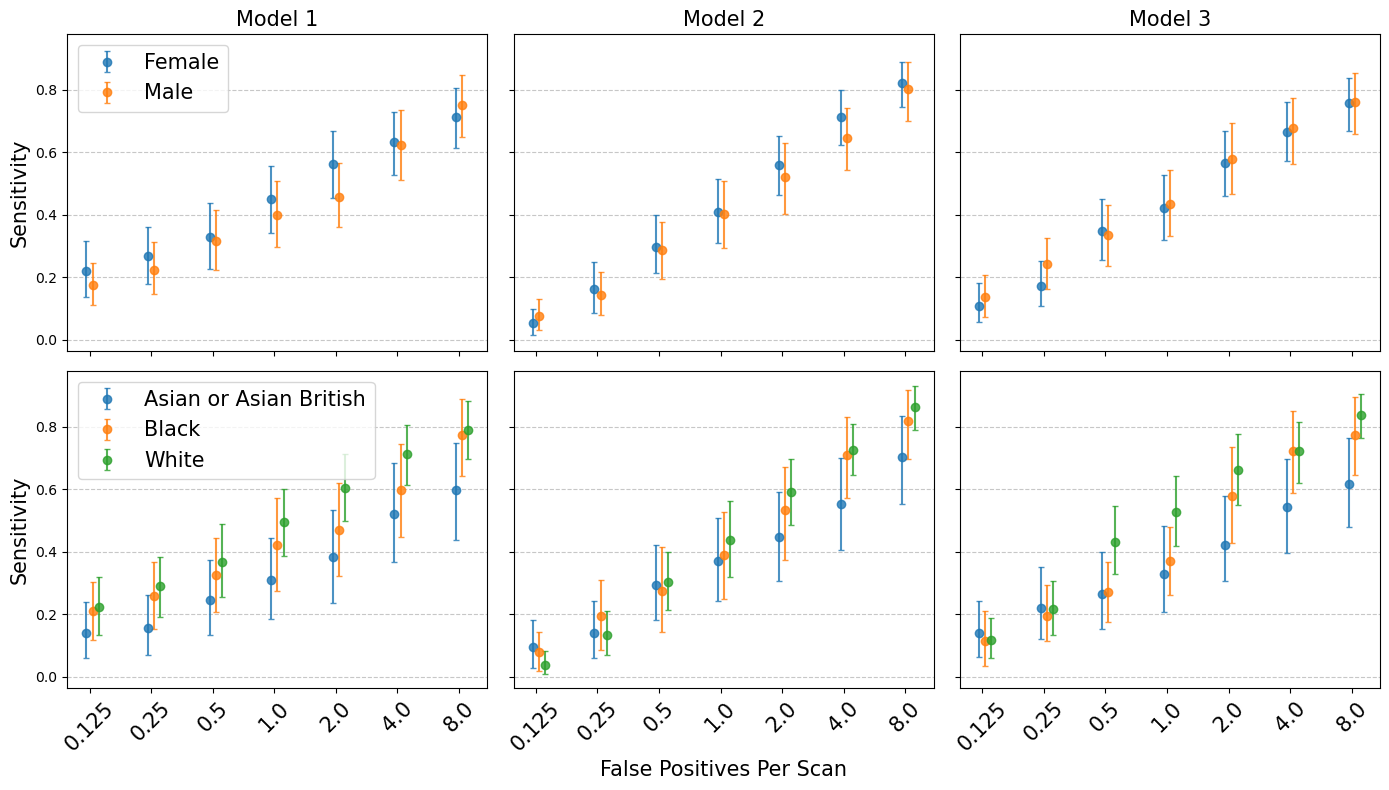

********************************************************************************
Flavour: male_only


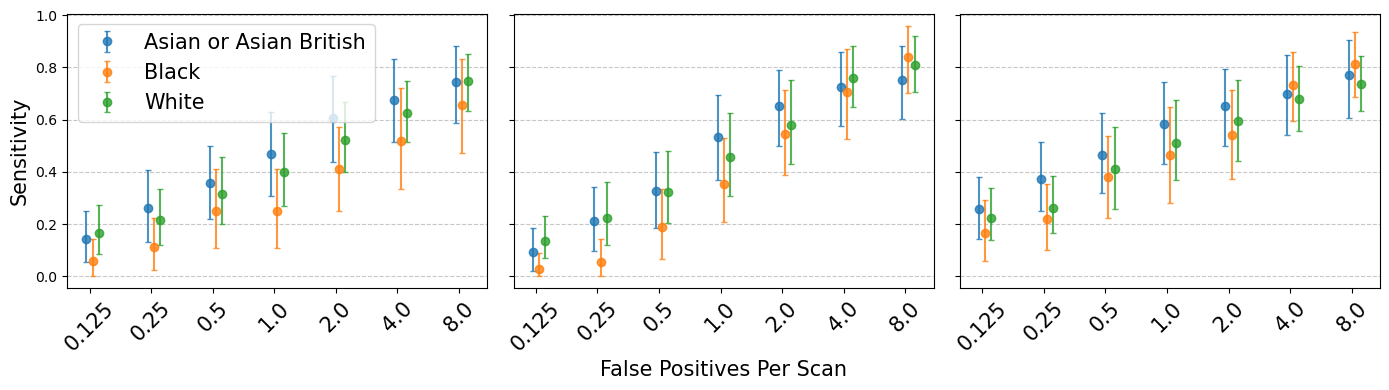

********************************************************************************
Flavour: white_only


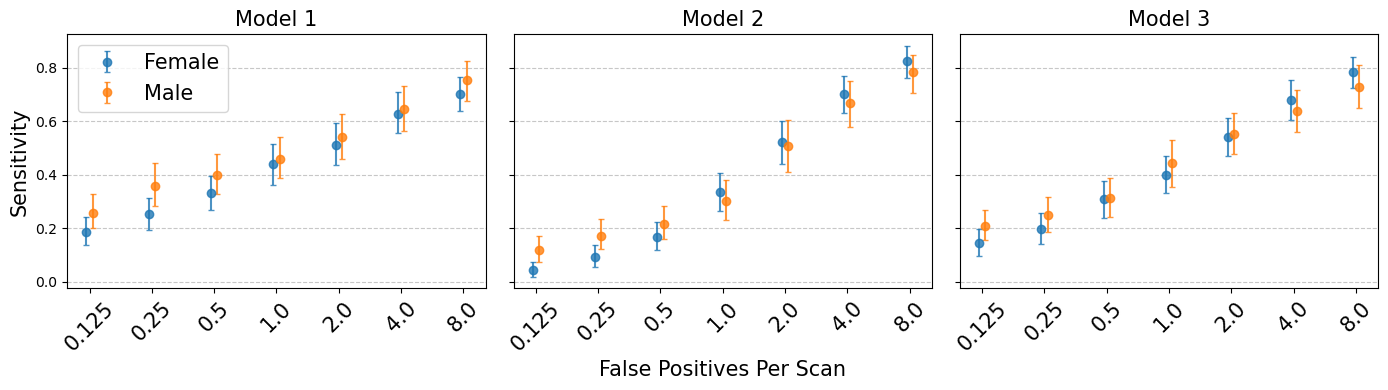

********************************************************************************
Flavour: test_balanced


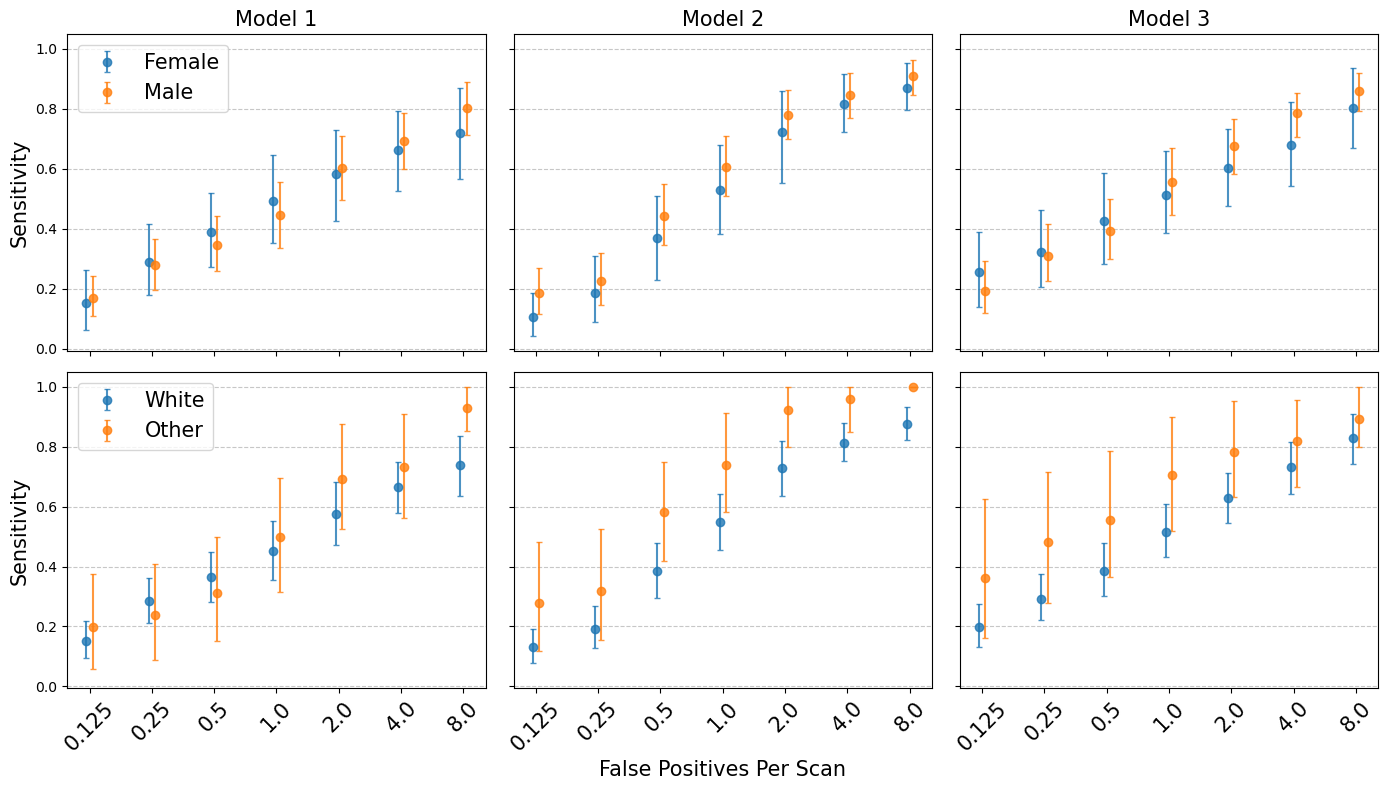

In [87]:
# Combine fixed froc data
from pathlib import Path
import json

p = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/FairnessInNoduleDetectionAlgorithms/results/summit/detection_test_balanced_froc_fixed_thresholds.json')
json_data = json.load(p.open())

fpps_recode = {0 : 0.125, 1 : 0.25, 2 : 0.5, 3 : 1, 4 : 2, 5 : 4, 6 : 8}

data_list = []

for path in Path('results').rglob('*_froc_fixed_thresholds.json'):

    path_parts = path.parts
    dataset = path_parts[-2]
    filename = path.stem
    model = filename.split('_')[0]
    flavour = '_'.join(filename.split('_')[1:3])

    print(f"Dataset: {dataset}, Model: {model}, Flavour: {flavour}")

    json_data = json.load(path.open())

    for category, data in json_data.items():
        data_list.append(
            pd.DataFrame.from_dict(data, orient='index')
            .rename(columns={'mean_sens':'mean_sens', 'lower_sens':'low_sens', 'upper_sens':'high_sens'})
            .reset_index().rename(columns={'index':'threshold'})
            .reset_index().rename(columns={'index':'fpps'})
            .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
            .assign(category=category)
            .assign(dataset=dataset)
            .assign(model=model)
            .assign(flavour=flavour)
        )

froc_data = pd.concat(data_list)
froc_data.query('dataset == "summit" and flavour == "test_balanced" and category == "Black" and fpps == 0.125')


for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)


# Combine the nodule characteristics images

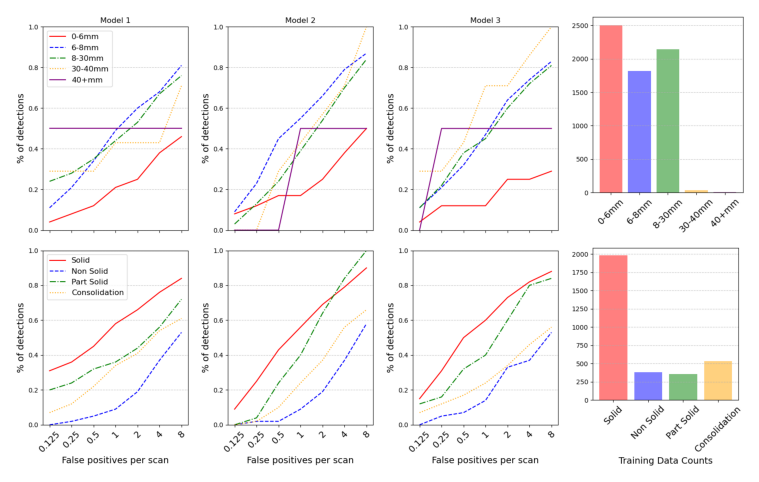

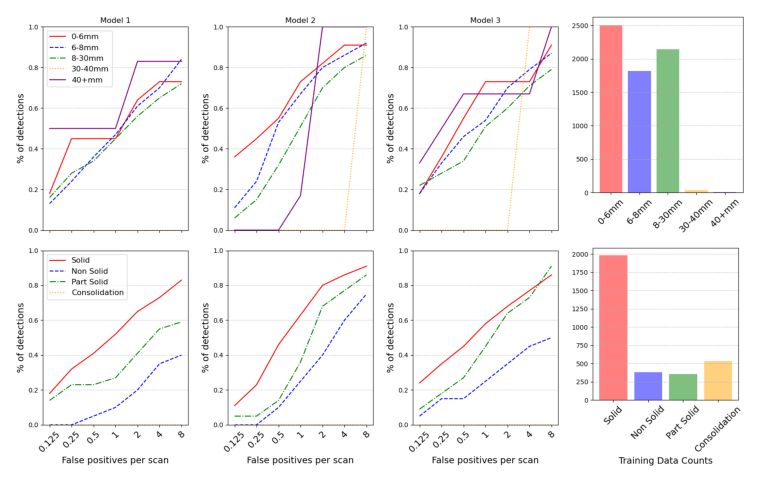

In [96]:
from PIL import Image
import matplotlib.pyplot as plt


for dataset in ['summit', 'lsut']:

    # Read the saved images
    img1 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_diameter_cats.png')
    img2 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_diameter_cats.png')
    img3 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_diameter_cats.png')
    img4 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_nodule_type.png')
    img5 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_nodule_type.png')
    img6 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_nodule_type.png')
    img7 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_diameter_cats.png')
    img8 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_nodule_type.png')

    # Get the size of the images
    width1, height1 = img1.size
    width2, height2 = img2.size
    width3, height3 = img3.size
    width4, height4 = img4.size
    width5, height5 = img5.size
    width6, height6 = img6.size
    width7, height7 = img7.size
    width8, height8 = img8.size


    # Create a new image with a size that can fit both images side by side
    combined_width = width1 + width2 + width3 + width7
    combined_height = max(height1, height2, height3, height7) + max(height4, height5, height6, height8)
    combined_img = Image.new("RGB", (combined_width, combined_height))

    # Paste the images into the combined image
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (width1, 0))
    combined_img.paste(img3, (width1 + width2, 0))
    combined_img.paste(img7, (width1 + width2 + width3, 0))
    combined_img.paste(img4, (0, height1))
    combined_img.paste(img5, (width1, height2))
    combined_img.paste(img6, (width1 + width2, height3))
    combined_img.paste(img8, (width1 + width2 + width3, height7))

    # Save the combined image
    combined_img.save(f'results/extension/images/{dataset}_nodule_characteristics.png')

    # Display the combined image using matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(combined_img)
    ax.axis('off')  # Hide the axis
    plt.show()

# Statistical Analysis

In [29]:
import numpy as np
import cv2
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy import stats

def hist_comparison(data1, cat1, data2, cat2, bins, title, variable, density=True):

    hist1, bins1 = np.histogram(data1[variable], bins=bins, density=True)
    hist2, bins2 = np.histogram(data2[variable], bins=bins, density=True)

    hist1 = cv2.normalize(hist1, hist1).astype(np.float32)
    hist2 = cv2.normalize(hist2, hist2).astype(np.float32)

    print(f'Histogram comparison for {variable} for {title}')
    print(f'Correlation between {variable} and nodule diameter for {title} is {cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)}')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(data1[variable], bins=bins, density=density, alpha=0.6, color='red')
    ax[0].set_title(f'{variable} for {cat1} ppts')
    if density:
        ax[0].set_xlim(0, 80)
        ax[0].set_ylim(0, 0.2)


    ax[1].hist(data2[variable], bins=bins, density=density, alpha=0.6, color='blue')
    ax[1].set_title(f'{variable} for {cat2} ppts')
    if density:
        ax[1].set_xlim(0, 80)
        ax[1].set_ylim(0, 0.2)
    

    fig.suptitle(title)
    plt.show()

def differences_bar_chart(data1, cat1, data2, cat2, variable, title):

    values1 = data1[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat1}').to_frame()
    values2 = data2[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat2}').to_frame()

    values = values1.merge(values2, left_index=True, right_index=True, how='outer').fillna(0)

    # Calculate differences
    differences = values[f'{variable}_{cat1}'] - values[f'{variable}_{cat2}']

    display(differences)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(differences.index, differences, color=['blue' if value < 0 else 'red' for value in differences])


    # Add labels and title
    ax.set_xticklabels(differences.index, rotation=45)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Difference')
    ax.set_title(f'Difference Bar Chart: {variable}')
    # Function to format y-tick labels as percentages with sign
    def percentage_with_sign(x, pos):
        return f'{np.abs(x)*100:.0f}%'

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_with_sign))


    positive_patch = Patch(color='red', label=f'{cat1} greater than {cat2}')
    negative_patch = Patch(color='blue', label=f'{cat2} greater than {cat1}')
    ax.legend(handles=[positive_patch, negative_patch])

    # Show the plot
    plt.show()

def chi_square_test(data1, cat1, data2, cat2, variable):
    # Create the crosstab with absolutes
    xabs = (
        pd.DataFrame(
            data1[variable]
            .value_counts()
            .sort_index()
        )
        .merge(
            pd.DataFrame(
                data2[variable]
                .value_counts()
                .sort_index()
            ),
            left_index=True,
            right_index=True,
            how='outer',
            suffixes=('_'+cat1, '_'+cat2))
        .fillna(0)
    ).astype(int)

    # Calculate the chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(xabs)

    print(f'Chi-square test for {variable} between {cat1} and {cat2}')
    print(f'Chi2: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies table:')
    # display(pd.DataFrame(expected, index=xabs.index, columns=xabs.columns))

    return chi2, p, dof, expected

nodule_type,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All
ethnic_group,,,,,
Asian or Asian British,0.104651,0.093023,0.069767,0.232558,0.5
Black,0.094595,0.108108,0.027027,0.270270,0.5
White,0.054878,0.103659,0.030488,0.310976,0.5
All,0.077160,0.101852,0.040123,0.280864,0.5


nodule_type,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All
ethnic_group,,,,,
Asian or Asian British,0.076923,0.146154,0.046154,0.230769,0.5
Black,0.080645,0.088710,0.032258,0.298387,0.5
White,0.101942,0.063107,0.072816,0.262136,0.5
All,0.089130,0.093478,0.054348,0.263043,0.5


Chi-square test results:
Chi2: 13.744180865300782
p-value: 0.5450128854167515
Degrees of freedom: 15
Expected frequencies table:
[[  7.85204082  11.14795918]
 [ 11.15816327  15.84183673]
 [  4.95918367   7.04081633]
 [ 20.66326531  29.33673469]
 [  7.0255102    9.9744898 ]
 [  7.85204082  11.14795918]
 [  2.47959184   3.52040816]
 [ 23.55612245  33.44387755]
 [ 12.39795918  17.60204082]
 [ 12.39795918  17.60204082]
 [  8.26530612  11.73469388]
 [ 43.39285714  61.60714286]
 [ 27.2755102   38.7244898 ]
 [ 31.40816327  44.59183673]
 [ 15.70408163  22.29591837]
 [ 87.6122449  124.3877551 ]]


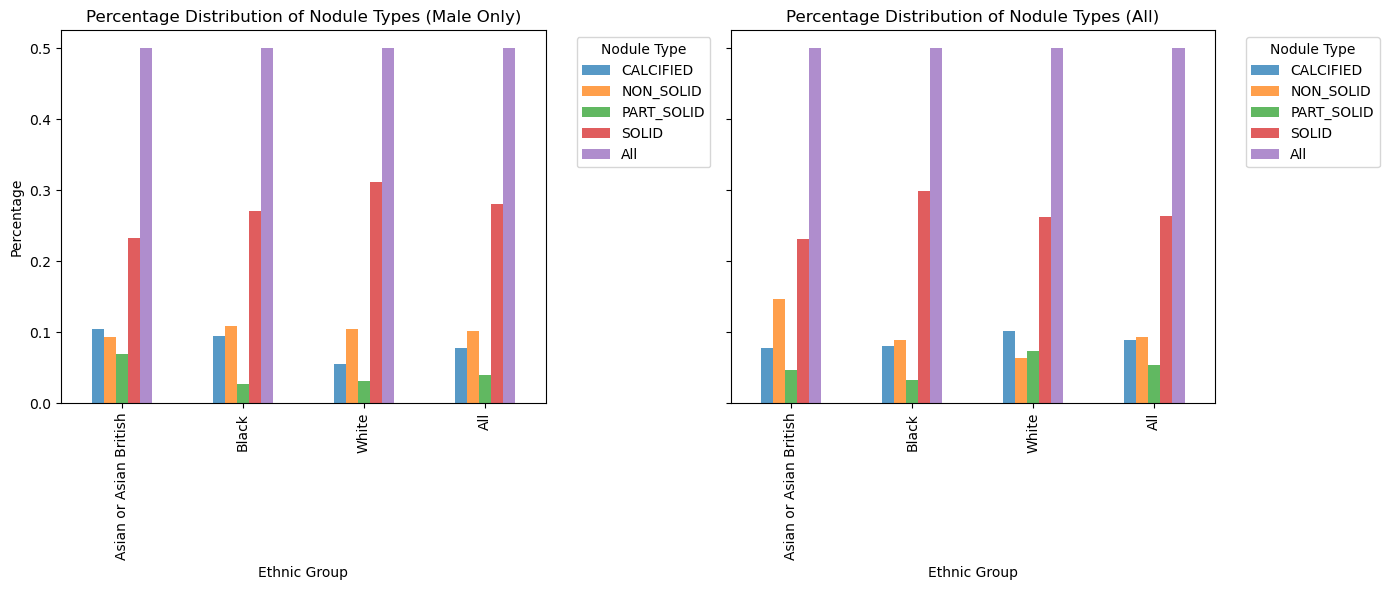

In [48]:
import matplotlib.pyplot as plt

def get_xtab(data):
    crosstab = pd.crosstab(
        data['ethnic_group'],
        data['nodule_type'],
        margins="index",
    )
    crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0)

    crosstab_combined = crosstab.astype(str) + ' (' + crosstab_percentage.astype(str) + ')' 

    return crosstab, crosstab_percentage, crosstab_combined

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/male_only/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
mo_abs, mo_perc, mo_combined = get_xtab(data)

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/test_balanced/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
all_abs, all_perc, all_combined = get_xtab(data)

display(mo_perc)
display(all_perc)

# Unravel mo_abs and all_abs
mo_abs_unravel = mo_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])
all_abs_unravel = all_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])

combined_long = pd.merge(mo_abs_unravel, all_abs_unravel, on='ethnic_grp_and_subtype', suffixes=('_mo', '_all'))

# Run chi-square test
chi2, p, dof, expected = stats.chi2_contingency(combined_long[['count_mo', 'count_all']])

print(f'Chi-square test results:')
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of freedom: {dof}')
print(f'Expected frequencies table:')
print(expected)

# Plotting side by side bar plots for mo_perc and all_perc

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Plot for mo_perc
mo_perc.plot(kind='bar', ax=axes[0], alpha=0.75)
axes[0].set_title('Percentage Distribution of Nodule Types (Male Only)')
axes[0].set_xlabel('Ethnic Group')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for all_perc
all_perc.plot(kind='bar', ax=axes[1], alpha=0.75)
axes[1].set_title('Percentage Distribution of Nodule Types (All)')
axes[1].set_xlabel('Ethnic Group')
axes[1].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
